In [2]:
import cv2
import math
import csv
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import ultralytics
import random
import supervision as sv 
import numpy as np

from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from ultralytics.solutions.solutions import BaseSolution
from ultralytics.utils.plotting import Annotator, colors
from datetime import datetime
%matplotlib inline

2025-03-11 16:59:02.829810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 16:59:02.837023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 16:59:02.845773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-11 16:59:02.848849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 16:59:02.856019: I tensorflow/core/platform/cpu_feature_guar

In [3]:
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Verifica si TensorFlow detecta la GPU
if tf.config.list_physical_devices('GPU'):
    print("¡GPU encontrada!")
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("¡GPU no encontrada!")

¡GPU encontrada!
Num GPUs Available:  1


I0000 00:00:1741708747.545836   30449 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741708747.547301   30449 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741708747.547475   30449 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


https://www.digitalocean.com/community/tutorials/what-is-new-with-yolo

## EJERCICIO 1 
Vamos a usar el modleo YOLOv11 para detectar objetos en una imagen (en este caso vamos a aplicar el modelo directamente sin entrenarlo).
Vamos a aplicarlo en las imagenes deteccion_objetos.jpg y bus.jpg

Partiendo de la imagen deteccion_objetos.jpg y bus.jpg.



In [ ]:
ruta_imgs = 'datos/imagenes/'
imgs_arr = [ruta_imgs+"deteccion_objetos.jpg",ruta_imgs+"bus.jpg"]
# cargar modelo yolo11
model = ultralytics.YOLO("recursos/5_5/yolo/yolo11n.pt")   

results = model(imgs_arr)
for res in results:
    res.show()

## EJERCICIO 2
Vamos a repetir el ejercicio pero ahora vamos a modificar la salida para que quede de la siguiente forma:

![Imagen con la el resultado que se quiere obtener 1](datos/imagenes//deteccion_objetos_solucion.png)

![Imagen con la el resultado que se quiere obtener 1](datos/imagenes//bus_solucion.png)

Además sólo quiero que detecte los objetos cuya probabilidad sea mayor al 50%.

Ten en cuenta que al aplicar el modelo a una imagen devuelve diferentes datos:
 * Cajas:
    * Clase (cls)
    * Probabilidad (score)
    * Coordenadas de la caja xyxy

Para representar la imagen y añadir rectángulos, texto... puedes usar Image, ImageDraw, ImageFont de PIL. Dibujas la imagen con .Draw de (ImageDraw) con .rectangle y .text puedes ir añadiendo texto y rectángulos.

In [4]:
clases = results[0].names
colores = ['cyan','orange','pink','green','yellow','red','blue','white']
guia = {}

In [ ]:
for idx,res in enumerate(results, start=0):    
    boxes = res.boxes  # Boxes object for bounding box outputs
    txt = ''
    filtrados = []
    for jdx,(cls,prob,coords) in enumerate(zip(boxes.cls,boxes.conf,boxes.xyxy)):
        if prob > 0.5:      # probabilidad mayor del 50%            
            # datos prediccion
            filtrados.append([cls,prob,coords])
            txt += 'Elemento {}--> Clase: {},\t Probabilidad: {},\t Coordenadas: {}\n'.format(jdx, clases[int(cls)], prob, coords)
            if int(cls) not in guia.keys(): 
                print(len(guia.keys()))
                guia[int(cls)] = colores[len(guia.keys())]
    # imagen
    img = Image.open(imgs_arr[idx])
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf", size=30)

    for i,caso in enumerate(filtrados):
        coords = caso[2]
        color = guia[int(caso[0])]
        draw.rectangle([coords[0], coords[1], coords[2], coords[3]], outline=color, width=5)
        draw.rectangle([coords[0], coords[1]-30, coords[0]+2 + 40, coords[1]],fill="black")
        draw.rectangle([coords[0]+2, coords[1]-28, coords[0] + 40, coords[1]-2],fill=color)
        draw.text((coords[0]+8, coords[1]-32), str(i), fill="black",font=font)

    # mostrar resultados
    plt.figure(figsize=(13,7))
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    print(txt)

## EJERCICIO 3
YOLOv11 también sirve para segmentación, aplica segmentación a las dos imágenes con las que estamos trabajando

In [6]:
model = ultralytics.YOLO('recursos/5_5/yolo/yolo11n-seg.pt')  

ruta_imgs = 'datos/imagenes/'
imgs_arr = [ruta_imgs+"deteccion_objetos.jpg",ruta_imgs+"bus.jpg"]


for img in imgs_arr:
    results = model(img)  
    results[0].show()



image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/deteccion_objetos.jpg: 640x640 11 persons, 9 bicycles, 3 cars, 1 backpack, 5.0ms
Speed: 1.9ms preprocess, 5.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


## EJERCICIO 4
De manera similar, podemos hacer la estimación de pose. Hazlo con las imágenes con las que estamos trabajando.

In [ ]:
model = ultralytics.YOLO('recursos/5_5/yolo/yolo11n-pose.pt')  

ruta_imgs = 'datos/imagenes/'
imgs_arr = [ruta_imgs+"deteccion_objetos.jpg",ruta_imgs+"bus.jpg"]


for img in imgs_arr:
    results = model(img)  
    results[0].show()


## EJERCICIO 5
Haz lo que se hace en el siguiente video:

https://www.youtube.com/watch?v=_YbEna8UNcU

Tienes parte del código en:

https://www.albertcoronado.com/2024/11/12/tutorial-yolo-11/

Para la parte fine tuning tienes que entrenar el modelo para que distina matrículas de coche, para entrenar el modelo utiliza el dataset que puedes descargar de:

https://universe.roboflow.com/parag-parmar-3qpin/car_license_plate-ypwmk/dataset/1

NOTA: HE CONSEGUIDO QUE FUNCIONE BIEN CV2 PERO ABRIENDO PRIMERO UNA IMAGEN:
```
img = cv2.imread('Datos/image3.jpg')
cv2.imshow("SAPA", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
```

In [ ]:
# camara
model = YOLO("recursos/5_5/yolo/yolo11x.pt")
cap = cv2.VideoCapture(0)

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.7
color = (0, 250, 0)
thickness = 2

while True:
    success, img = cap.read()
    results = model( img, stream=True )

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            confidence = math.ceil((box.conf[0]*100))
            
            cv2.rectangle(img, ( x1, y1 ), ( x2, y2 ), color, 1)
            cv2.putText(img, r.names[ int( box.cls[0] ) ]+" "+str(confidence)+"%", [ x1+4, y1+25 ], font, fontScale, color, thickness)

    cv2.imshow('Webcam', img)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
#segmentation 
model = ultralytics.YOLO('recursos/5_5/yolo/fine_tunning.pt')  

img='datos/imagenes/matricula.jpg'


results = model(img)  
results[0].show()


## EJERCICIO 6
Repite el fine tuning del apartado anterior pero ahora en vez de como un comando en la terminal con código de python

In [ ]:
# Load a model  
model = ultralytics.YOLO("recursos/5_5/yolo/yolo11s.pt")

# Train the model  
model.train(data="datos/datasets/matriculas_yolo/data.yaml", #path to yaml file  
           imgsz=400, #image size for training  
           batch=10, #number of batch size  
           epochs=25, #number of epochs  
           device=0) #device ‘0’ if gpu else ‘cpu’


In [ ]:
model = ultralytics.YOLO('runs/detect/train5/weights/best.pt')  

img='datos/imagenes/matricula.jpg'


results = model(img)  
results[0].show()


## EJERCICIO 7
Vamos a contar los pasajeros de un autobus.

Sigue las instrucciones del siguiente video:

https://www.youtube.com/watch?v=hTI0Aj__SLE

ELIMINA LOS COMENTARIOS QUE HAY EN EL CÓDIGO Y COMENTA EL CÓDIGO CON TUS PROPIAS PALABRAS


In [4]:
class ObjectCounter(BaseSolution):
    """
    Clase para contar objetos en tiempo real en un video.
    La clase cuenta los objetos que entran de una región previamente definida, pudiendo ser tanto linear como poligonal.
    
    Attributes:
        in_count (int): Conteo de objetos entrantes.
        out_count (int): Conteo de objetos salientes.
        counted_ids (List[int]): Lista de IDs de los objetos contados.
        saved_ids (List[int]): Lista de los IDs guardados en el CSV.
        classwise_counts (Dict[str, Dict[str, int]]): Diccionario para los objetos contados, categorizados por las clases de los objetos.
        region_initialized (bool): Un indicador para indicar (valga la redundancia) si la zona de conteo ha sido iniciada.
        show_in (bool): Control del display del conteo de entrada.
        show_out (bool): Control del display del conteo de salida.
    """

    def __init__(self, **kwargs):
        # Inicializa la clase ObjetCounter para el conteo de objetos en tiempo real en video.
        super().__init__(**kwargs)

        self.in_count = 0  # Conteo de objetos entrantes.
        self.out_count = 0  # Conteo de objetos salientes.
        self.counted_ids = []  # Lista de IDs de los objetos contados.
        self.saved_ids = []  # Lista de los IDs guardados en el CSV.
        self.classwise_counts = {}  # Diccionario para los objetos contados, categorizados por las clases de los objetos.
        self.region_initialized = False  # Un indicador para indicar (valga la redundancia) si la zona de conteo ha sido iniciada.

        self.show_in = self.CFG.get("show_in", True)
        self.show_out = self.CFG.get("show_out", True)

    def save_label_to_csv(self, track_id, label, action):
        # Guarda la etiqueta, el track_id, la acción y la hora actual en un nuevo archivo CSV con la fecha actual.
        if track_id in self.saved_ids:
            return  # Omite el guardado si el ID ya está guardado

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        current_date = datetime.now().strftime("%Y-%m-%d")  # Obtiene la fecha actual como cadena

        # Crea un nombre de archivo usando la fecha actual
        filename = f'tracked_objects_{current_date}.csv'

        # Verifica si el archivo existe para decidir si se deben escribir los encabezados
        file_exists = os.path.isfile(filename)

        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)

            # Escribe los encabezados solo si el archivo no existe
            if not file_exists:
                writer.writerow(['track_id', 'label', 'action', 'date', 'time'])

            # Escribe la fila de datos con la columna de acción
            writer.writerow([track_id, label, action, current_time.split()[0], current_time.split()[1]])
            self.saved_ids.append(track_id)  # Marca el ID como guardado


    def count_objects(self, current_centroid, track_id, prev_position, cls):
        """
        Cuenta los objetos dentro de una región poligonal o lineal basándose en sus trayectorias.

        Argumentos:
            current_centroid (Tuple[float, float]): Valores del centroide actual en el fotograma actual.
            track_id (int): Identificador único para el objeto rastreado.
            prev_position (Tuple[float, float]): Coordenadas de la posición en el fotograma anterior (x, y) de la trayectoria.
            cls (int): Índice de la clase para actualizar el conteo por clases.
        """
        if prev_position is None or track_id in self.counted_ids:
            return

        action = None # La acción predeterminada es None

        if len(self.region) == 2:  # Región lineal (definida como un segmento de línea)
            line = self.LineString(self.region)
            if line.intersects(self.LineString([prev_position, current_centroid])):
                if abs(self.region[0][0] - self.region[1][0]) < abs(self.region[0][1] - self.region[1][1]):
                    if current_centroid[0] > prev_position[0]:  # Moviéndose hacia la derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia la izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Moviéndose hacia abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        elif len(self.region) > 2:  # Región poligonal
            polygon = self.Polygon(self.region)
            if polygon.contains(self.Point(current_centroid)):
                region_width = max([p[0] for p in self.region]) - min([p[0] for p in self.region])
                region_height = max([p[1] for p in self.region]) - min([p[1] for p in self.region])

                if region_width < region_height:
                    if current_centroid[0] > prev_position[0]:  # Moviéndose hacia la derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia la izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Moviéndose hacia abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        # Guarda la etiqueta con la acción
        if action:
            label = f"{self.names[cls]} ID: {track_id}"
            self.save_label_to_csv(track_id, label, action)

    def store_classwise_counts(self, cls):
        # Inicializa el conteo por clases para una clase de objeto específica si no está presente.
        if self.names[cls] not in self.classwise_counts:
            self.classwise_counts[self.names[cls]] = {"IN": 0, "OUT": 0}

    def display_counts(self, im0):
        # Muestra los conteos de objetos en la imagen o fotograma de entrada.
        labels_dict = {
            str.capitalize(key): f"{'IN ' + str(value['IN']) if self.show_in else ''} "
            f"{'OUT ' + str(value['OUT']) if self.show_out else ''}".strip()
            for key, value in self.classwise_counts.items()
            if value["IN"] != 0 or value["OUT"] != 0
        }

        if labels_dict:
            self.annotator.display_analytics(im0, labels_dict, (104, 31, 17), (255, 255, 255), 10)

        for track_id in self.track_ids:
            if track_id in self.counted_ids:
                in_count = self.in_count
                label = f"ID:{track_id} count at number {in_count}"
                self.annotator.box_label(self.boxes[self.track_ids.index(track_id)], label=label, color=(255, 255, 0))

    def count(self, im0):
        # Procesa los datos de entrada (fotogramas o rastreos de objetos) y actualiza los conteos de objetos.
        if not self.region_initialized:
            self.initialize_region()
            self.region_initialized = True

        self.annotator = Annotator(im0, line_width=self.line_width)
        self.extract_tracks(im0)
        self.annotator.draw_region(reg_pts=self.region, color=(104, 0, 123), thickness=self.line_width * 2)

        for box, track_id, cls in zip(self.boxes, self.track_ids, self.clss):
            self.store_tracking_history(track_id, box)
            self.store_classwise_counts(cls)

            label = f"{self.names[cls]} ID: {track_id}"
            self.annotator.box_label(box, label=label, color=colors(cls, True))

            current_centroid = ((box[0] + box[2]) / 2, (box[1] + box[3]) / 2)
            prev_position = self.track_history[track_id][-2] if len(self.track_history[track_id]) > 1 else None
            self.count_objects(current_centroid, track_id, prev_position, cls)

        self.display_counts(im0)
        self.display_output(im0)

        return im0

In [ ]:
# Definir la función de callback del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprobar el movimiento del ratón
        point = [x, y]
        print(f"Ratón movido a: {point}")

# Abrir el archivo de video
cap = cv2.VideoCapture('datos/videos/1.mp4')

# Definir puntos de la región para el conteo
region_points = [(386,103), (458, 499)]

# Inicializar el contador de objetos
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="recursos/5_5/yolo/yolo11s.pt",  # Modelo para el conteo de objetos
    classes=[0],  # Detectar solo la clase persona
    show_in=True,  # Mostrar el conteo de entradas
    show_out=True,  # Mostrar el conteo de salidas
    line_width=2,  # Ajustar el grosor de la línea para la visualización
)

# Crear una ventana con nombre y establecer el callback del ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

count = 0

while True:
    # Leer un fotograma del video
    ret, frame = cap.read()
    if not ret:
        break
        # Si el video termina, reiniciar al principio
    #cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    #continue
    count += 1
    if count % 2 != 0:  # Saltar los fotogramas impares
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Procesar el fotograma con el contador de objetos
    frame = counter.count(frame)

    # Mostrar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Presionar 'q' para salir
        break

# Liberar el objeto de captura de video y cerrar la ventana de visualización
cap.release()
cv2.destroyAllWindows()

## EJERCICIO 8
Adapta el código anterior para que cuente vehículos en el video vehicle-counting.mp4 (tiene que contar por separado coches y camiones)

In [ ]:
# Definir la función de callback del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprobar el movimiento del ratón
        point = [x, y]
        print(f"Ratón movido a: {point}")

# Abrir el archivo de video
cap = cv2.VideoCapture('datos/videos/vehicle-counting.mp4')

# Definir puntos de la región para el conteo
region_points = [(150,300), (950, 300)]

# Inicializar el contador de objetos
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="recursos/5_5/yolo/yolo11s.pt",  # Modelo para el conteo de objetos
    classes=[2,7],  # Detectar solo las clases de coche y camiones
    show_in=True,  # Mostrar el conteo de entradas
    show_out=True,  # Mostrar el conteo de salidas
    line_width=2,  # Ajustar el grosor de la línea para la visualización
)

# Crear una ventana con nombre y establecer el callback del ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

count = 0

while True:
    # Leer un fotograma del video
    ret, frame = cap.read()
    if not ret:
        break
        # Si el video termina, reiniciar al principio
    #cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    #continue
    count += 1
    if count % 2 != 0:  # Saltar los fotogramas impares
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Procesar el fotograma con el contador de objetos
    frame = counter.count(frame)

    # Mostrar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Presionar 'q' para salir
        break

# Liberar el objeto de captura de video y cerrar la ventana de visualización
cap.release()
cv2.destroyAllWindows()

## EJERCICIO 9
Adapta el ejercicio anterior para que en vez de coches cuente matrículas usando el modelo que has creado en el ejercicio 6. 

Si el video del apartado anterior no te sirve porque no se ven bien las matrículas crea un video con la IA generativa (si el video creado es demasiado corto junta varios videos en uno)

In [ ]:
# Definir la función de callback del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprobar el movimiento del ratón
        point = [x, y]
        print(f"Ratón movido a: {point}")

# Abrir el archivo de video
cap = cv2.VideoCapture('datos/videos/prueba.mp4')

# Definir puntos de la región para el conteo
region_points = [(0,500), (1020, 0)]

# Inicializar el contador de objetos
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="runs/detect/train5/weights/best.pt",  # Modelo para el conteo de objetos
    classes=[0],  # Detectar solo la clase matriculas
    show_in=True,  # Mostrar el conteo de entradas
    show_out=True,  # Mostrar el conteo de salidas
    line_width=2,  # Ajustar el grosor de la línea para la visualización
)

# Crear una ventana con nombre y establecer el callback del ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

count = 0

while True:
    # Leer un fotograma del video
    ret, frame = cap.read()
    if not ret:
        break
        # Si el video termina, reiniciar al principio
    #cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    #continue
    count += 1
    if count % 2 != 0:  # Saltar los fotogramas impares
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Procesar el fotograma con el contador de objetos
    frame = counter.count(frame)

    # Mostrar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Presionar 'q' para salir
        break

# Liberar el objeto de captura de video y cerrar la ventana de visualización
cap.release()
cv2.destroyAllWindows()

## EJERCICIO 10
Vamos a hacer fine tuning sobre el modelo para segmentación SAM-2.

Puedes sacar información de la siguiente página:

https://blog.roboflow.com/fine-tune-sam-2-1/

A la hora de conseguir el dataset, descargalo para no tener problemas con la API-KEY de Roboflow

In [3]:
!git clone https://github.com/facebookresearch/sam2.git
!wget -O /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2/sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'



Clonando en 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Recibiendo objetos: 100% (1070/1070), 134.70 MiB | 15.29 MiB/s, listo.
Resolviendo deltas: 100% (376/376), listo.
--2025-02-11 17:31:17--  https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3
Resolviendo drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.178.161, 2a00:1450:4003:80d::2001
Conectando con drive.usercontent.google.com (drive.usercontent.google.com)[142.250.178.161]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 11055 (11K) [application/octet-stream]
Guardando como: ‘/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2/sam2/configs/train.yaml’

/home/iabd/IABD_242 100%[===================>]  10,80K  --.-KB/s    en 0s      

2025-02-11 17:31:20 (105 MB/s) - ‘/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2/sam2/configs/t

In [4]:
%cd ./sam2/
!pip install -e .[dev]
!pip install supervision -q


/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2
Obtaining file:///home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13846 sha256=964917cfd6b7342ecce0c977334f62753cd1cfb009be6c0a7e714e406d2f9678
  Stored in directory: /tmp/pip-ephem-wheel-cache-6g3fz2mb/wheels/c5/26/02/4351d66e25c433a365de0ac57e3637660aba824f59d0957197
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0


In [5]:
!cd ./checkpoints && ./download_ckpts.sh

--2025-02-11 17:32:05--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolviendo dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.41.8, 18.154.41.57, 18.154.41.12, ...
Conectando con dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)[18.154.41.8]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 156008466 (149M) [application/vnd.snesdev-page-table]
Guardando como: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148,78M  45,4MB/s    en 3,4s    

2025-02-11 17:32:08 (44,3 MB/s) - ‘sam2.1_hiera_tiny.pt’ guardado [156008466/156008466]

--2025-02-11 17:32:08--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolviendo dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.41.12, 18.154.41.57, 18.154.41.96, ...
Conectando con dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)[18.154.41.12]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitu

In [6]:
%cd ..

/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios


In [7]:

FOLDER = "datos/datasets/Car_Parts/train"

for filename in os.listdir(FOLDER):
	# Replace all except last dot with underscore
	new_filename = filename.replace(".", "_", filename.count(".") - 1)
	if not re.search(r"_\d+\.\w+$", new_filename):
		# Add an int to the end of base name
		new_filename = new_filename.replace(".", "_1.")
	os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

In [8]:
FOLDER = "datos/datasets/Car_Parts/test"

for filename in os.listdir(FOLDER):
	# Replace all except last dot with underscore
	new_filename = filename.replace(".", "_", filename.count(".") - 1)
	if not re.search(r"_\d+\.\w+$", new_filename):
		# Add an int to the end of base name
		new_filename = new_filename.replace(".", "_1.")
	os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

In [9]:
FOLDER = "datos/datasets/Car_Parts/valid"

for filename in os.listdir(FOLDER):
	# Replace all except last dot with underscore
	new_filename = filename.replace(".", "_", filename.count(".") - 1)
	if not re.search(r"_\d+\.\w+$", new_filename):
		# Add an int to the end of base name
		new_filename = new_filename.replace(".", "_1.")
	os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

In [10]:
%cd sam2/

/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2


In [11]:
!python training/train.py -c 'configs/train.yaml' --use-cluster 0 --num-gpus 1

/home/iabd/anaconda3/envs/IABD3_12/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
###################### Train App Config ####################
scratch:
  resolution: 1024
  train_batch_size: 1
  num_train_workers: 10
  num_frames: 1
  max_num_objects: 3
  base_lr: 5.0e-06
  vision_lr: 3.0e-06
  phases_per_epoch: 1
  num_epochs: 40
dataset:
  img_folder: /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/datasets/Car_Parts/train
  gt_folder: /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/datasets/Car_Parts/train
  multiplier: 2
vos:
  train_transforms:
  - _target_: training.dataset.transforms.ComposeAPI
    transforms:
    - _target_: training.dataset.transforms.RandomHorizontalFlip
      consis

In [ ]:
!ls 

In [12]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA no disponible")

2.6.0+cu124
12.4
True
NVIDIA GeForce RTX 4080 Laptop GPU


In [13]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2

torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
	torch.backends.cuda.matmul.allow_tf32 = True
	torch.backends.cudnn.allow_tf32 = True

checkpoint = "/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2/sam2_logs/configs/train.yaml/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2)

checkpoint_base = "/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/sam2/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg_base = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)

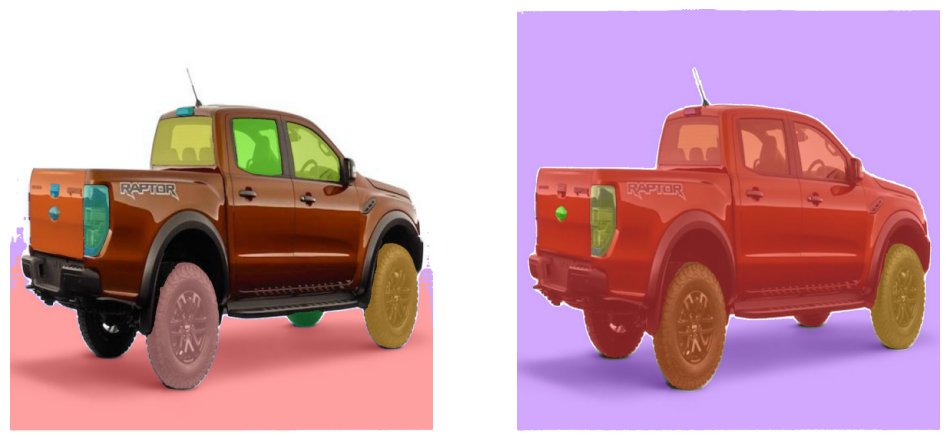

In [16]:
validation_set = os.listdir("/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/datasets/Car_Parts/valid")

# choose random with .json extension
image = random.choice([img for img in validation_set if img.endswith(".jpg")])
image = os.path.join("/home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/datasets/Car_Parts/valid", image)
opened_image = np.array(Image.open(image).convert("RGB"))
result = mask_generator.generate(opened_image)

detections = sv.Detections.from_sam(sam_result=result)

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
annotated_image = opened_image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)

base_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

base_result = mask_generator_base.generate(opened_image)
base_detections = sv.Detections.from_sam(sam_result=base_result)
base_annotated_image = opened_image.copy()
base_annotated_image = base_annotator.annotate(base_annotated_image, detections=base_detections)

sv.plot_images_grid(images=[annotated_image, base_annotated_image], grid_size=(1, 2))


## EJERCICIO 11 (OPCIONAL)
Haz fine tuning con sam2 o yolo11 para segmentación con otro dataset 

## EJERCICIO 12 (OPCIONAL)
En el siguiente enlace encontraras diferentes modelos y trabajos sobre la visión por computación, prueba alguno de ellos (algunos que no funcionan porque las librerías se han actualizado y tienes que adaptarlos, otros son recientes y no deberías tener problemas).

https://github.com/roboflow/notebooks

ELIMINA LOS COMENTARIOS QUE HAY EN EL CÓDIGO Y COMENTA EL CÓDIGO CON TUS PROPIAS PALABRAS